In [ ]:
import numpy as np
from scipy.linalg import solve
from joblib import Parallel, delayed
import os
import gc

def log_to_file(message, log_file="log.txt"):
    print(message + "\n")
    with open(log_file, "a") as f:  # 'a' mode appends to the file
        f.write(message + "\n")

def get_op(ori,nn):
        d=ori[0].shape[0]
        n_qubits=len(nn[0])
        d_op=2**n_qubits
    
        labels=[np.binary_repr(i).zfill(n_qubits)  for i in np.arange(0,d_op)] 
        masks=[np.fromiter(label, dtype=int) for label in labels]

        op_zero=[np.zeros((2**n_qubits,2**n_qubits)) for i in range(d)]
        OPs=[]
        N=ori.shape[0]

        for agent_idx in range(N):
            nn_agent_ids=nn[agent_idx]
            op=op_zero # one operator for each dimension being used.

            if(n_qubits != len(nn_agent_ids)): 
                print(len(nn_agent_ids), n_qubits)
                OPs.append(op_zero)
                continue

            n_qubits = len(nn_agent_ids)
            ori_nns=ori[nn_agent_ids,:] 

            for dim in range(d): # for each component of operator direction
                for i in range(d_op):
                    for j in range(d_op):
                        if(i != j): op[dim][i,j]= (masks[i].dot(ori_nns[:,dim]) + masks[j].dot(ori_nns[:,dim]))

            OPs.append(op)
        
        return OPs

# Function to find X given O and dO/dt
# dO/dt=[O,X]=AX ; goal is to find X given O and dO/dt
def find_X(O, dO_dt):
    
    try:
        O += np.eye(O.shape[0]) * 1e-10
        dO_dt += np.eye(dO_dt.shape[0]) * 1e-10

        n = O.shape[0]
        # Create the augmented matrix for the system of equations
        A = np.kron(np.eye(n), O) - np.kron(O.T, np.eye(n))  # Kronecker product for the equation OX - XO = D
        b = dO_dt.flatten()  # Flatten dO/dt to match dimensions    
        Ainv=np.asarray(np.linalg.pinv(A))
        X_flat=Ainv@b
        X = X_flat.reshape(n, n)
        return X
    except Exception as e:
        error_message = str(e)
        log_to_file(error_message,"error.txt")
        return np.zeros(O.shape)
        
def get_allagents_eigenvals(OP):
    E_all=[]
    for agent_idx in range(len(OP)):
            E=[]
            for op_dim in OP[agent_idx]:
                E_dim=np.linalg.eigvals(op_dim)
                E.append(E_dim)
            E_all.append(E)
    return np.asarray(E_all)

def get_allagents_energies(OP1,OP2):
    E_all=[]
    for agent_idx in range(len(OP1)):
            E=[]
            for idx, op1_dim in enumerate(OP1[agent_idx]):
                op2_dim=OP2[agent_idx][idx]
                H=find_X(op1_dim, op2_dim-op1_dim)
                E_dim=np.linalg.eigvals(1.0j*H)
                E.append(E_dim)

            E_all.append(E)
    return np.asarray(E_all)

def get_OP_history(ori_history,nn_history):
        n_steps=len(ori_history)
        OP_history = Parallel(n_jobs=-1)(delayed(get_op)
                                             (ori_history[idx], nn_history[idx]) for idx in range(n_steps))
        return np.asarray(OP_history)
      
def get_OP_eigen_history(OP_history): 
    n_steps=len(OP_history)
    eigen_history = Parallel(n_jobs=-1)(delayed(get_allagents_eigenvals)
                                            (OP_history[idx]) for idx in range(n_steps))
    return np.asarray(eigen_history)      

def get_energy_history(OP_history):
    n_steps=len(OP_history)
    energy_history = Parallel(n_jobs=-1)(delayed(get_allagents_energies)
                                            (OP_history[idx],OP_history[idx+1]) for idx in range(n_steps-1))
    return np.asarray(energy_history)  
    
def get_phi_history(ori_history):
    return np.linalg.norm(np.mean(ori_history,axis=1),axis=1)

def make_dir(results_folder):
    if not os.path.exists(results_folder):
        os.makedirs(results_folder)
        print(f"Folder '{results_folder}' created.")
    else:
        print(f"Folder '{results_folder}' already exists.")
     
def run(output_folder="output_rmin0.001"):

    make_dir(output_folder)

    labels=[]
    n_qubits=[]

    labels +=['bell1','bell2','bell3','bell4','w_state']
    labels +=['ghz_state','cluster2_1','cluster3_1','cluster3_2']
    n_qubits +=[2,2,2,2,3,3,2,3,3]

    labels +=['cluster4_1','cluster4_2','cluster4_3','cluster4_4','cluster4_5','cluster4_6']
    n_qubits +=[4,4,4,4,4,4]

    etas=np.linspace(0,2.0,21)

    # all_data={}
    for idx,label in enumerate(labels):
        log_to_file(f"started {idx}, {label} ************")

        data_eta={}

        results_folder=f"{output_folder}/results"
        make_dir(results_folder)
        gc.collect()

        for eta in etas:
            nn=n_qubits[idx]
            label=labels[idx]
            eta=np.round(eta,1)

            log_to_file(f"started eta {eta}")

            filename=f"{output_folder}/traj_nn{nn}_{label}_eta{eta}.npy"

            X=np.load(filename,allow_pickle=True).item()['X']
            V=np.load(filename,allow_pickle=True).item()['V']
            NN=np.load(filename,allow_pickle=True).item()['NN']
            X=np.asarray(X)
            V=np.asarray(V)

            OP_history=get_OP_history(V,NN)
            eigen_history=get_OP_eigen_history(OP_history)
            energy_history=get_energy_history(OP_history)
            phi_history=get_phi_history(V)
            
            data_eta[eta]={'phi':phi_history,'eigen':eigen_history,'energy':energy_history}
            
        res_filename=f"{output_folder}/results/res_{label}.npy"
        np.save(res_filename,data_eta)
        # all_data[label]=data_eta

    # np.save(f'op_data_summary_{output_folder}',all_data)

output_folders=['output_alpha180_rmin0.1_rmax5.0',
                'output_alpha90_rmin0.1_rmax5.0',
                'output_rmin0.001',
                'output_rmin1.0']

# output_folders=['output_rmin0.001',
#                 'output_rmin1.0']

for output_folder in output_folders:
    log_to_file(f"{output_folder} *********************************\n")
    run(output_folder)

In [ ]:
import numpy as np
import matplotlib.pyplot as plt
import gzip
import seaborn as sns

labels=['bell1','bell2','bell3','bell4','w_state']
labels +=['ghz_state',
        'cluster2_1','cluster3_1','cluster3_2',
        'cluster4_1','cluster4_2','cluster4_3','cluster4_4','cluster4_5','cluster4_6']

output_folders=['output_alpha180_rmin0.1_rmax5.0',
                'output_alpha90_rmin0.1_rmax5.0',
                'output_rmin0.001',
                'output_rmin1.0']

for output_folder in output_folders:
        all_data={}
        for label in labels:
                pvector_all_eta=[]
                energy_all_eta=[]
                phi_all_eta=[]
                for eta in np.linspace(0,2,21):
                        eta=np.round(eta,1)
                        # output_folder='output_alpha180_rmin0.1_rmax5.0'
                        res_filename=f"{output_folder}/results/res_{label}.npy"
                        data=np.load(res_filename,allow_pickle=True).item()
                        phi=data[eta]['phi']
                        eigen=data[eta]['eigen']
                        energy=data[eta]['energy']
                
                        energy_eta= np.sum(np.sum(np.max(energy,axis=3),axis=2),axis=1)  
                        # np.mean(np.sum(np.max(energy,axis=3),axis=2))
                        pvector_eta=np.linalg.norm(np.mean(np.max(np.abs(eigen),axis=3),axis=1),axis=1)
                        
                        pvector_all_eta.append(pvector_eta)
                        energy_all_eta.append(energy_eta)
                        phi_all_eta.append(phi)

                all_data[label]={'phi':phi_all_eta,'energy':np.real(energy_all_eta), 'perception':np.real(pvector_all_eta)}
                        
        # np.save(f"combined_{output_folder}",data)
        with gzip.GzipFile(f"combined_{output_folder}.npy.gz", "w") as f:
                np.save(f, all_data)

In [2]:
import gzip
import numpy as np
import matplotlib.pyplot as plt
import gzip
import seaborn as sns

with gzip.GzipFile("combined_output_alpha180_rmin0.1_rmax5.0.npy.gz", "r") as f:
    alldata180 = np.load(f,allow_pickle=True).item()

with gzip.GzipFile("combined_output_alpha90_rmin0.1_rmax5.0.npy.gz", "r") as f:
    alldata90 = np.load(f,allow_pickle=True).item()

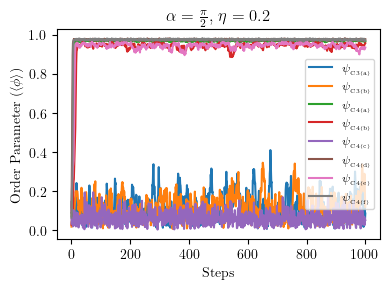

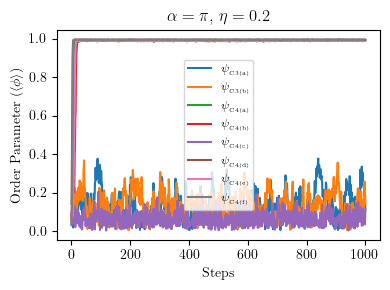

In [4]:

plt.rcParams['text.latex.preamble'] = r'\usepackage{amsmath}'  # Load amsmath package
# plt.rc('font', family='serif', serif=['Computer Modern Roman'])  # Set LaTeX font

plt.rc('text', usetex=True)
plt.rc('font', family='serif')

plt.figure(figsize=(4, 3))
steps=np.linspace(0,1000,1001)


# labels=['bell1','bell2','bell3','bell4','w_state','ghz_state']
labels =['cluster3_1','cluster3_2',
         'cluster4_1','cluster4_2','cluster4_3','cluster4_4','cluster4_5','cluster4_6']

for label in labels:
    plt.plot(alldata90[label]['phi'][2])

plt.xlabel(r'Steps')
plt.ylabel(r'Order Parameter ($\langle \phi \rangle$)')
# plt.title()
plt.legend([r'$\psi_{_\text{C3(a)}}$',r'$\psi_{_\text{C3(b)}}$',
            r'$\psi_{_\text{C4(a)}}$',r'$\psi_{_\text{C4(b)}}$',r'$\psi_{_\text{C4(c)}}$',
            r'$\psi_{_\text{C4(d)}}$',r'$\psi_{_\text{C4(e)}}$',r'$\psi_{_\text{C4(f)}}$',], fontsize='small')


plt.title(r'$\alpha=\frac{\pi}{2}$, $\eta=0.2$')
plt.tight_layout()
plt.savefig(f'plots/op_alpha90_2.pdf',bbox_inches='tight')

plt.show()

plt.figure(figsize=(4, 3))
steps=np.linspace(0,1000,1001)

# labels=['bell1','bell2','bell3','bell4','w_state','ghz_state']
labels =['cluster3_1','cluster3_2',
        'cluster4_1','cluster4_2','cluster4_3','cluster4_4','cluster4_5','cluster4_6']

for label in labels:
    plt.plot(alldata180[label]['phi'][1])

plt.xlabel(r'Steps')
plt.ylabel(r'Order Parameter ($\langle \phi \rangle$)')
# plt.title()
plt.legend([r'$\psi_{_\text{C3(a)}}$',r'$\psi_{_\text{C3(b)}}$',
            r'$\psi_{_\text{C4(a)}}$',r'$\psi_{_\text{C4(b)}}$',r'$\psi_{_\text{C4(c)}}$',
            r'$\psi_{_\text{C4(d)}}$',r'$\psi_{_\text{C4(e)}}$',r'$\psi_{_\text{C4(f)}}$',], fontsize='small')


plt.title(r'$\alpha=\pi$, $\eta=0.2$')

plt.tight_layout()
plt.savefig(f'plots/op_alpha180_2.pdf',bbox_inches='tight')

plt.show()


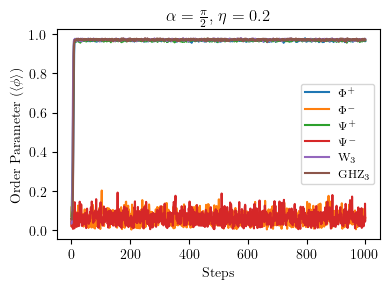

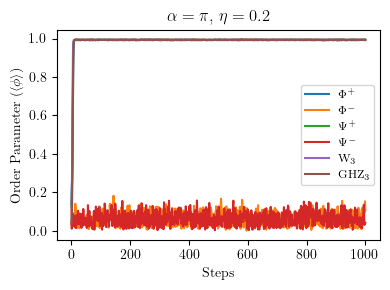

In [8]:

plt.rcParams['text.latex.preamble'] = r'\usepackage{amsmath}'  # Load amsmath package
# plt.rc('font', family='serif', serif=['Computer Modern Roman'])  # Set LaTeX font

plt.rc('text', usetex=True)
plt.rc('font', family='serif')

plt.figure(figsize=(4, 3))
steps=np.linspace(0,1000,1001)


labels=['bell1','bell2','bell3','bell4','w_state','ghz_state']
# labels =['cluster3_1','cluster3_2',
#         'cluster4_1','cluster4_2','cluster4_3','cluster4_4','cluster4_5','cluster4_6']

for label in labels:
    plt.plot(alldata90[label]['phi'][2])

plt.xlabel(r'Steps')
plt.ylabel(r'Order Parameter ($\langle \phi \rangle$)')
# plt.title()
plt.legend([r'$\Phi^+$',r'$\Phi^-$',
            r'$\Psi^+$',r'$\Psi^-$',
            r'$\text{W}_3$',r'$\text{GHZ}_3$'], fontsize='small')

plt.title(r'$\alpha=\frac{\pi}{2}$, $\eta=0.2$')
plt.tight_layout()
plt.savefig(f'plots/op_alpha90_1.pdf',bbox_inches='tight')

plt.show()


plt.figure(figsize=(4, 3))
steps=np.linspace(0,1000,1001)


labels=['bell1','bell2','bell3','bell4','w_state','ghz_state']
# labels +=['cluster3_1','cluster3_2',
#         'cluster4_1','cluster4_2','cluster4_3','cluster4_4','cluster4_5','cluster4_6']

for label in labels:
    plt.plot(alldata180[label]['phi'][1])

plt.xlabel(r'Steps')
plt.ylabel(r'Order Parameter ($\langle \phi \rangle$)')
# plt.title()
plt.legend([r'$\Phi^+$',r'$\Phi^-$',
            r'$\Psi^+$',r'$\Psi^-$',
            r'$\text{W}_3$',r'$\text{GHZ}_3$'], fontsize='small')

plt.title(r'$\alpha=\pi$, $\eta=0.2$')
plt.tight_layout()
plt.savefig(f'plots/op_alpha180_1.pdf',bbox_inches='tight')

plt.show()




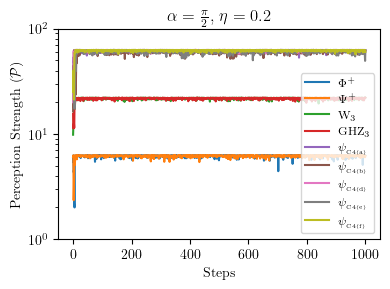

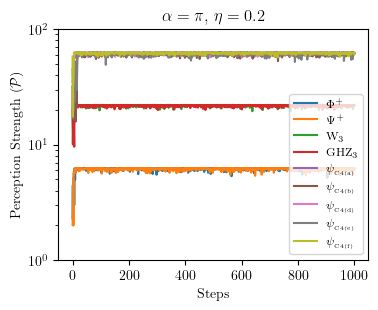

In [10]:

plt.rcParams['text.latex.preamble'] = r'\usepackage{amsmath}'  # Load amsmath package
# plt.rc('font', family='serif', serif=['Computer Modern Roman'])  # Set LaTeX font

plt.rc('text', usetex=True)
plt.rc('font', family='serif')

plt.figure(figsize=(4, 3))
steps=np.linspace(0,1000,1001)


labels=['bell1','bell3','w_state','ghz_state']
legnds=[r'$\Phi^+$',
            r'$\Psi^+$',
            r'$\text{W}_3$',r'$\text{GHZ}_3$']

labels +=['cluster4_1','cluster4_2','cluster4_4','cluster4_5','cluster4_6']

legnds+= [r'$\psi_{_\text{C4(a)}}$',r'$\psi_{_\text{C4(b)}}$',
            r'$\psi_{_\text{C4(d)}}$',r'$\psi_{_\text{C4(e)}}$',r'$\psi_{_\text{C4(f)}}$']

for label in labels:
    plt.plot(alldata90[label]['perception'][2])

plt.xlabel(r'Steps')
plt.ylabel(r'Perception Strength ($\cal{P}$)')
# plt.title()
plt.yscale('log')
plt.ylim([1,100])

plt.legend(legnds, fontsize='small')

plt.title(r'$\alpha=\frac{\pi}{2}$, $\eta=0.2$')
plt.tight_layout()
plt.savefig(f'plots/perception_alpha90.pdf',bbox_inches='tight')

plt.show()


plt.figure(figsize=(4, 3))
steps=np.linspace(0,1000,1001)


labels=['bell1','bell3','w_state','ghz_state']
legnds=[r'$\Phi^+$',
            r'$\Psi^+$',
            r'$\text{W}_3$',r'$\text{GHZ}_3$']

labels +=['cluster4_1','cluster4_2','cluster4_4','cluster4_5','cluster4_6']

legnds+= [r'$\psi_{_\text{C4(a)}}$',r'$\psi_{_\text{C4(b)}}$',
            r'$\psi_{_\text{C4(d)}}$',r'$\psi_{_\text{C4(e)}}$',r'$\psi_{_\text{C4(f)}}$']

for label in labels:
    plt.plot(alldata180[label]['perception'][2])

plt.xlabel(r'Steps')
plt.ylabel(r'Perception Strength ($\cal{P}$)')
# plt.title()

plt.yscale('log')
plt.ylim([1,100])

plt.legend(legnds, fontsize='small')

plt.title(r'$\alpha=\pi$, $\eta=0.2$')
# plt.tight_layout()
plt.savefig(f'plots/perception_alpha180.pdf',bbox_inches='tight')

plt.show()




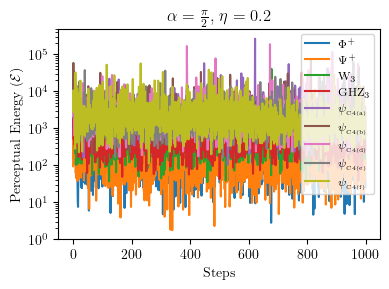

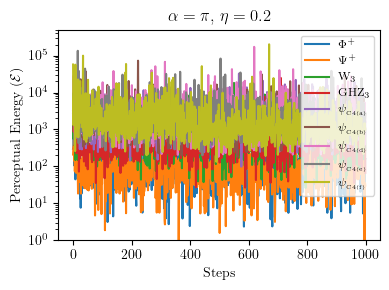

In [11]:

plt.rcParams['text.latex.preamble'] = r'\usepackage{amsmath}'  # Load amsmath package
# plt.rc('font', family='serif', serif=['Computer Modern Roman'])  # Set LaTeX font

plt.rc('text', usetex=True)
plt.rc('font', family='serif')

plt.figure(figsize=(4, 3))
steps=np.linspace(0,1000,1001)


labels=['bell1','bell3','w_state','ghz_state']
legnds=[r'$\Phi^+$',
            r'$\Psi^+$',
            r'$\text{W}_3$',r'$\text{GHZ}_3$']

labels +=['cluster4_1','cluster4_2','cluster4_4','cluster4_5','cluster4_6']

legnds+= [r'$\psi_{_\text{C4(a)}}$',r'$\psi_{_\text{C4(b)}}$',
            r'$\psi_{_\text{C4(d)}}$',r'$\psi_{_\text{C4(e)}}$',r'$\psi_{_\text{C4(f)}}$']

for label in labels:
    plt.plot(alldata90[label]['energy'][2])

plt.xlabel(r'Steps')
plt.ylabel(r'Perceptual Energy ($\cal{E}$)')
# plt.title()
plt.ylim([1,500000])
plt.legend(legnds, fontsize='small')
plt.yscale('log')

plt.title(r'$\alpha=\frac{\pi}{2}$, $\eta=0.2$')
plt.tight_layout()
plt.savefig(f'plots/energy_alpha90.pdf',bbox_inches='tight')

plt.show()


plt.figure(figsize=(4, 3))
steps=np.linspace(0,1000,1001)


labels=['bell1','bell3','w_state','ghz_state']
legnds=[r'$\Phi^+$',
            r'$\Psi^+$',
            r'$\text{W}_3$',r'$\text{GHZ}_3$']

labels +=['cluster4_1','cluster4_2','cluster4_4','cluster4_5','cluster4_6']

legnds+= [r'$\psi_{_\text{C4(a)}}$',r'$\psi_{_\text{C4(b)}}$',
            r'$\psi_{_\text{C4(d)}}$',r'$\psi_{_\text{C4(e)}}$',r'$\psi_{_\text{C4(f)}}$']

for label in labels:
    plt.plot(alldata180[label]['energy'][2])

plt.xlabel(r'Steps')
plt.ylabel(r'Perceptual Energy ($\cal{E}$)')
# plt.title()
plt.yscale('log')
plt.legend(legnds, fontsize='small')
plt.ylim([1,500000])
plt.title(r'$\alpha=\pi$, $\eta=0.2$')
plt.tight_layout()
plt.savefig(f'plots/energy_alpha180.pdf',bbox_inches='tight')

plt.show()




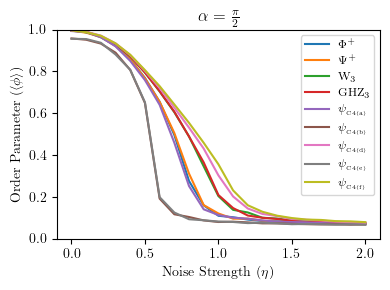

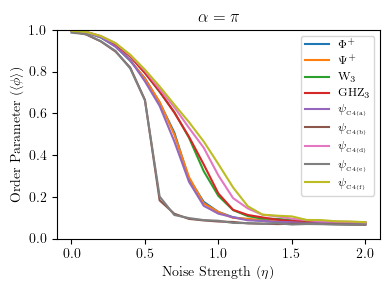

In [59]:

plt.rcParams['text.latex.preamble'] = r'\usepackage{amsmath}'  # Load amsmath package
# plt.rc('font', family='serif', serif=['Computer Modern Roman'])  # Set LaTeX font

plt.rc('text', usetex=True)
plt.rc('font', family='serif')

plt.figure(figsize=(4, 3))
steps=np.linspace(0,1000,1001)

etas=np.linspace(0,2,21)
labels=['bell1','bell3','w_state','ghz_state']
legnds=[r'$\Phi^+$',
            r'$\Psi^+$',
            r'$\text{W}_3$',r'$\text{GHZ}_3$']

labels +=['cluster4_1','cluster4_2','cluster4_4','cluster4_5','cluster4_6']

legnds+= [r'$\psi_{_\text{C4(a)}}$',r'$\psi_{_\text{C4(b)}}$',
            r'$\psi_{_\text{C4(d)}}$',r'$\psi_{_\text{C4(e)}}$',r'$\psi_{_\text{C4(f)}}$']

for label in labels:
    avg_list=[]
    for idx,eta in enumerate(etas):
        avg_list.append(np.mean(alldata90[label]['phi'][idx]))
    
    plt.plot(etas,avg_list)

plt.xlabel(r'Noise Strength ($\eta$)')
plt.ylabel(r'Order Parameter ($\langle \phi \rangle$)')
# plt.title()
plt.ylim([0,1])
plt.legend(legnds, fontsize='small')
# plt.yscale('log')

plt.title(r'$\alpha=\frac{\pi}{2}$')
plt.tight_layout()
plt.savefig(f'plots/op_eta_alpha90.pdf',bbox_inches='tight')

plt.show()


plt.figure(figsize=(4, 3))
steps=np.linspace(0,1000,1001)


labels=['bell1','bell3','w_state','ghz_state']
legnds=[r'$\Phi^+$',
            r'$\Psi^+$',
            r'$\text{W}_3$',r'$\text{GHZ}_3$']

labels +=['cluster4_1','cluster4_2','cluster4_4','cluster4_5','cluster4_6']

legnds+= [r'$\psi_{_\text{C4(a)}}$',r'$\psi_{_\text{C4(b)}}$',
            r'$\psi_{_\text{C4(d)}}$',r'$\psi_{_\text{C4(e)}}$',r'$\psi_{_\text{C4(f)}}$']

for label in labels:
    avg_list=[]
    for idx,eta in enumerate(etas):
        avg_list.append(np.mean(alldata180[label]['phi'][idx]))
    
    plt.plot(etas,avg_list)

plt.xlabel(r'Noise Strength ($\eta$)')
plt.ylabel(r'Order Parameter ($\langle \phi \rangle$)')
# plt.title()
# plt.yscale('log')
plt.legend(legnds, fontsize='small')
plt.ylim([0,1.0])
plt.title(r'$\alpha=\pi$')
plt.tight_layout()
plt.savefig(f'plots/op_eta_alpha180.pdf',bbox_inches='tight')

plt.show()




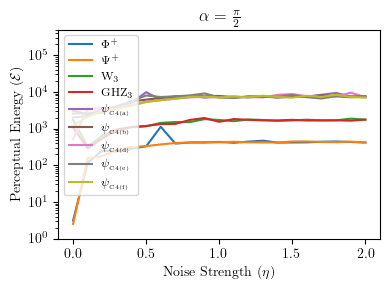

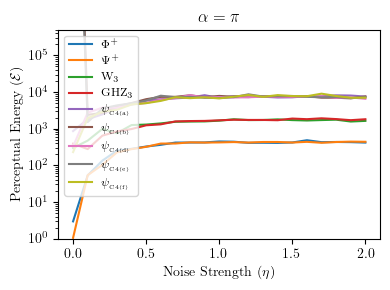

In [13]:

plt.rcParams['text.latex.preamble'] = r'\usepackage{amsmath}'  # Load amsmath package
# plt.rc('font', family='serif', serif=['Computer Modern Roman'])  # Set LaTeX font

plt.rc('text', usetex=True)
plt.rc('font', family='serif')

plt.figure(figsize=(4, 3))
steps=np.linspace(0,1000,1001)

etas=np.linspace(0,2,21)
labels=['bell1','bell3','w_state','ghz_state']
legnds=[r'$\Phi^+$',
            r'$\Psi^+$',
            r'$\text{W}_3$',r'$\text{GHZ}_3$']

labels +=['cluster4_1','cluster4_2','cluster4_4','cluster4_5','cluster4_6']

legnds+= [r'$\psi_{_\text{C4(a)}}$',r'$\psi_{_\text{C4(b)}}$',
            r'$\psi_{_\text{C4(d)}}$',r'$\psi_{_\text{C4(e)}}$',r'$\psi_{_\text{C4(f)}}$']

for label in labels:
    avg_list=[]
    for idx,eta in enumerate(etas):
        avg_list.append(np.mean(alldata90[label]['energy'][idx]))
    
    plt.plot(etas,avg_list)

plt.xlabel(r'Noise Strength ($\eta$)')
plt.ylabel(r'Perceptual Energy ($\cal{E}$)')
# plt.title()
plt.ylim([1,500000])
plt.legend(legnds, fontsize='small')
plt.yscale('log')

plt.title(r'$\alpha=\frac{\pi}{2}$')
plt.tight_layout()
plt.savefig(f'plots/energy_eta_alpha90.pdf',bbox_inches='tight')

plt.show()


plt.figure(figsize=(4, 3))
steps=np.linspace(0,1000,1001)


labels=['bell1','bell3','w_state','ghz_state']
legnds=[r'$\Phi^+$',
            r'$\Psi^+$',
            r'$\text{W}_3$',r'$\text{GHZ}_3$']

labels +=['cluster4_1','cluster4_2','cluster4_4','cluster4_5','cluster4_6']

legnds+= [r'$\psi_{_\text{C4(a)}}$',r'$\psi_{_\text{C4(b)}}$',
            r'$\psi_{_\text{C4(d)}}$',r'$\psi_{_\text{C4(e)}}$',r'$\psi_{_\text{C4(f)}}$']

for label in labels:
    avg_list=[]
    for idx,eta in enumerate(etas):
        avg_list.append(np.mean(alldata180[label]['energy'][idx]))
    
    plt.plot(etas,avg_list)

plt.xlabel(r'Noise Strength ($\eta$)')
plt.ylabel(r'Perceptual Energy ($\cal{E}$)')
# plt.title()
plt.yscale('log')
plt.legend(legnds, fontsize='small')
plt.ylim([1,500000])
plt.title(r'$\alpha=\pi$')
plt.tight_layout()
plt.savefig(f'plots/energy_eta_alpha180.pdf',bbox_inches='tight')

plt.show()




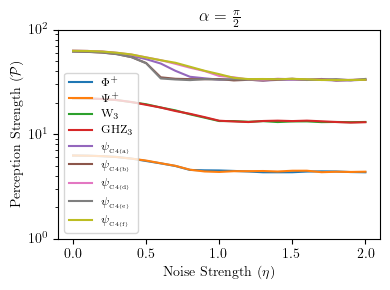

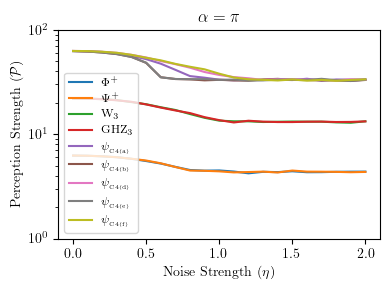

In [14]:

plt.rcParams['text.latex.preamble'] = r'\usepackage{amsmath}'  # Load amsmath package
# plt.rc('font', family='serif', serif=['Computer Modern Roman'])  # Set LaTeX font

plt.rc('text', usetex=True)
plt.rc('font', family='serif')

plt.figure(figsize=(4, 3))
steps=np.linspace(0,1000,1001)

etas=np.linspace(0,2,21)
labels=['bell1','bell3','w_state','ghz_state']
legnds=[r'$\Phi^+$',
            r'$\Psi^+$',
            r'$\text{W}_3$',r'$\text{GHZ}_3$']

labels +=['cluster4_1','cluster4_2','cluster4_4','cluster4_5','cluster4_6']

legnds+= [r'$\psi_{_\text{C4(a)}}$',r'$\psi_{_\text{C4(b)}}$',
            r'$\psi_{_\text{C4(d)}}$',r'$\psi_{_\text{C4(e)}}$',r'$\psi_{_\text{C4(f)}}$']

for label in labels:
    avg_list=[]
    for idx,eta in enumerate(etas):
        avg_list.append(np.mean(alldata90[label]['perception'][idx]))
    
    plt.plot(etas,avg_list)

plt.xlabel(r'Noise Strength ($\eta$)')
plt.ylabel(r'Perception Strength ($\cal{P}$)')
# plt.title()
plt.ylim([1,100])
plt.legend(legnds, fontsize='small')
plt.yscale('log')

plt.title(r'$\alpha=\frac{\pi}{2}$')
plt.tight_layout()
plt.savefig(f'plots/perception_eta_alpha90.pdf',bbox_inches='tight')

plt.show()


plt.figure(figsize=(4, 3))
steps=np.linspace(0,1000,1001)


labels=['bell1','bell3','w_state','ghz_state']
legnds=[r'$\Phi^+$',
            r'$\Psi^+$',
            r'$\text{W}_3$',r'$\text{GHZ}_3$']

labels +=['cluster4_1','cluster4_2','cluster4_4','cluster4_5','cluster4_6']

legnds+= [r'$\psi_{_\text{C4(a)}}$',r'$\psi_{_\text{C4(b)}}$',
            r'$\psi_{_\text{C4(d)}}$',r'$\psi_{_\text{C4(e)}}$',r'$\psi_{_\text{C4(f)}}$']

for label in labels:
    avg_list=[]
    for idx,eta in enumerate(etas):
        avg_list.append(np.mean(alldata180[label]['perception'][idx]))
    
    plt.plot(etas,avg_list)

plt.xlabel(r'Noise Strength ($\eta$)')
plt.ylabel(r'Perception Strength ($\cal{P}$)')
# plt.title()
plt.yscale('log')
plt.ylim([1,100])
plt.legend(legnds, fontsize='small')

plt.title(r'$\alpha=\pi$')
plt.tight_layout()
plt.savefig(f'plots/perception_eta_alpha180.pdf',bbox_inches='tight')

plt.show()


